### Time Series data

In [1]:
import pandas

df = pandas.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


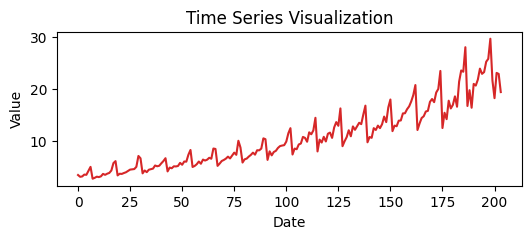

In [5]:
import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(6,2), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Time Series Visualization')

### Seasonality Plot

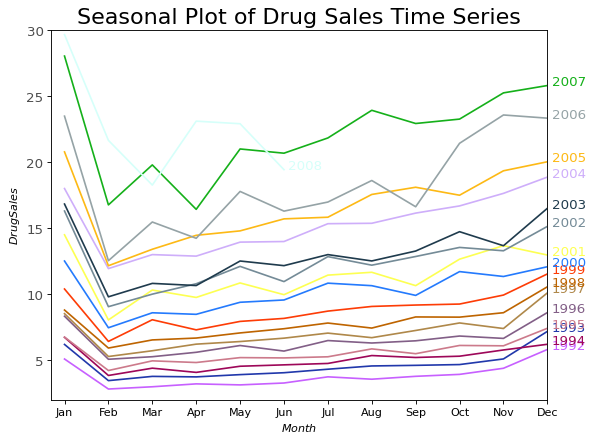

In [14]:
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

import numpy as np
import matplotlib as mpl
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(8,6), dpi= 80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

### Patterns in Time Series Data

Time Series = Base Level + Trend + Seasonality + Error

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

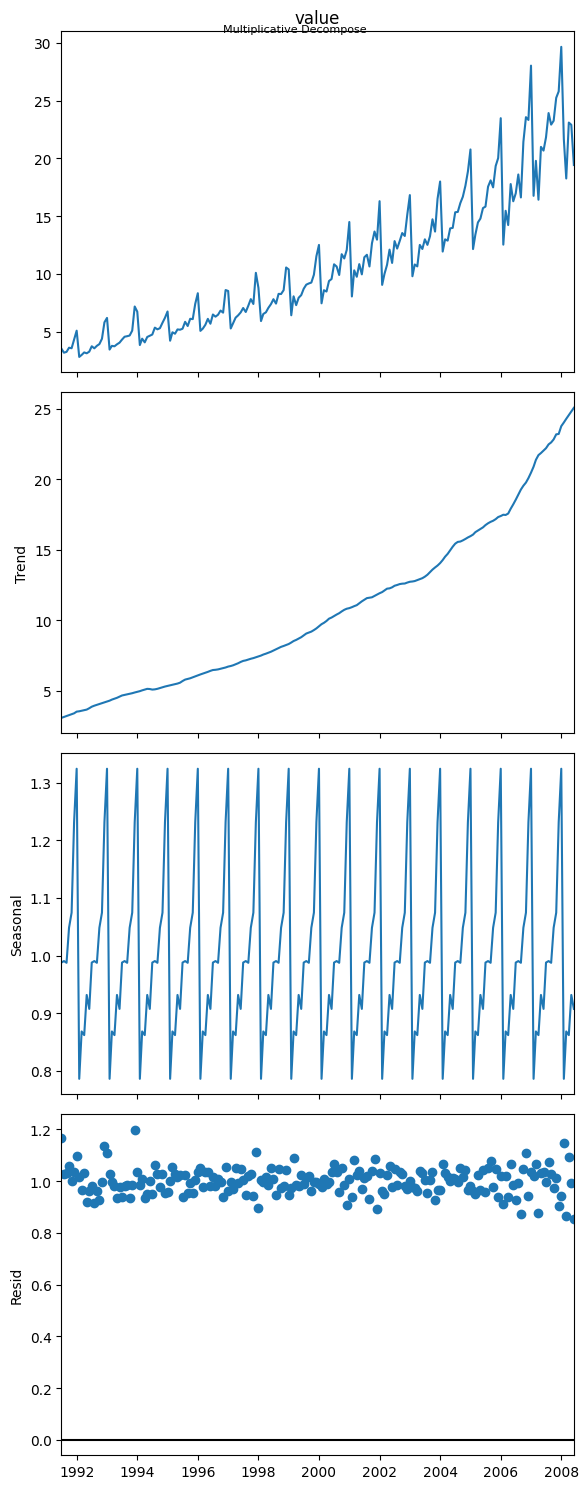

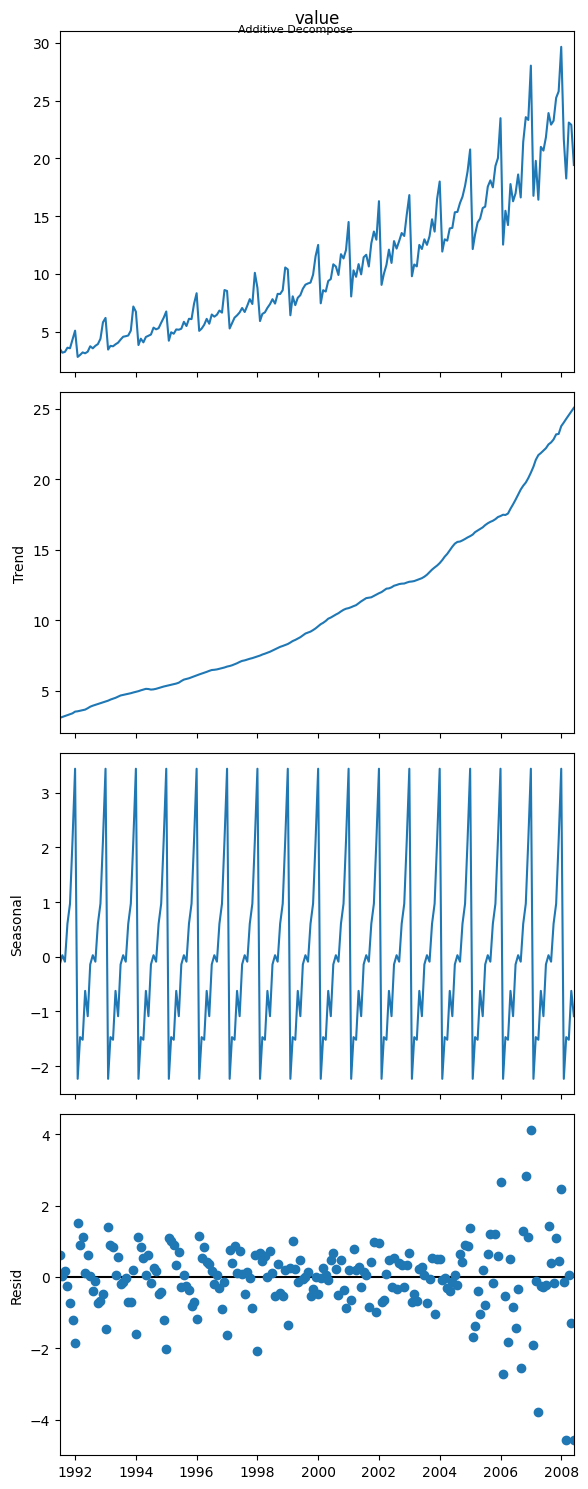

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

df = pandas.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (6,15)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=8)
result_add.plot().suptitle('Additive Decompose', fontsize=8)
plt.show()

### Stationary and Non-Stationary Time Series

A stationary series is one where the values of the series is not a function of time.

The statistical properties of the series like mean, variance and autocorrelation are constant over time. A stationary time series is devoid of seasonal effects as well.

You can make series stationary by:
  - Differencing the Series (once or more)
  - Take the log of the series
  - Take the nth root of the series
  - Combination of the above

Consider the following series: [1, 5, 2, 12, 20]

First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]

Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]

Forecasting a stationary series is relatively easy and the forecasts are more reliable.

There are multiple implementations tests:
  - Augmented Dickey Fuller test (ADH Test)
  - Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
  - Philips Perron test (PP Test)


In [23]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pandas.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.14518568930673
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 2.013126
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


<ipython-input-23-2b5270b13336>:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df.value.values, regression='c')


### How to detrend a time series?

- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.
- Subtract the trend component obtained from time series decomposition we saw earlier.
- Subtract the mean.
- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

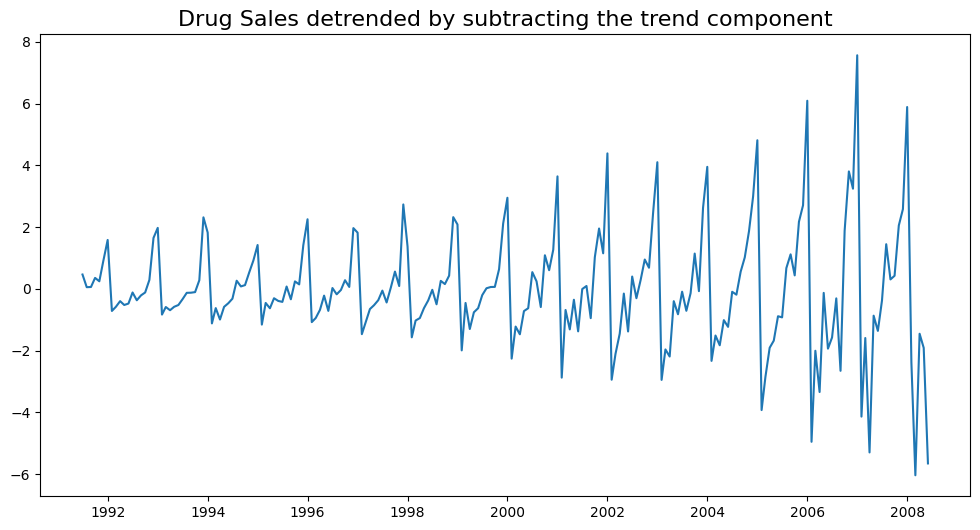

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pandas.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend

plt.figure(figsize=(12, 6))
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)
plt.show()

### How to deseasonalize a time series?

- Take a moving average with length as the seasonal window. This will smoothen in series in the process.

- Seasonal difference the series (subtract the value of previous season from the current value)

- Divide the series by the seasonal index obtained from STL decomposition

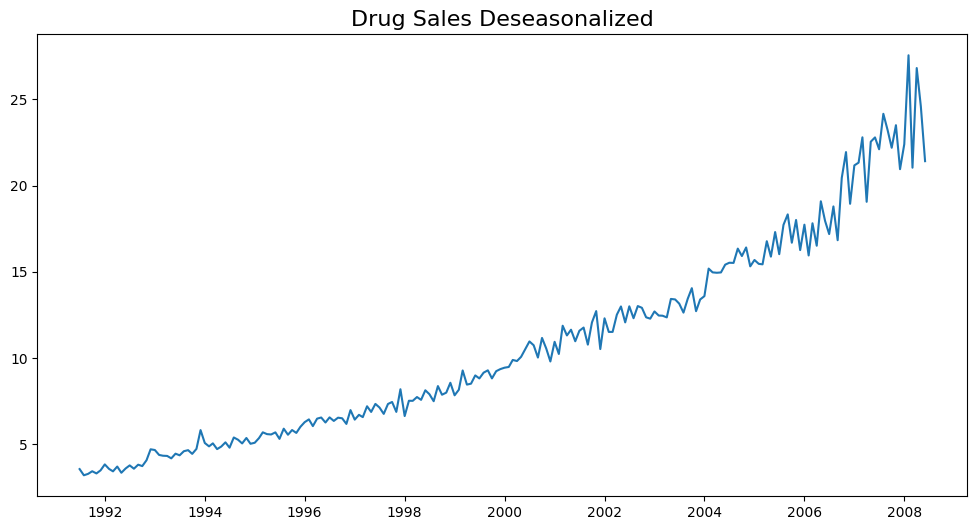

In [27]:
# Subtracting the Trend Component.
df = pandas.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

deseasonalized = df.value.values / result_mul.seasonal

plt.figure(figsize=(12, 6))
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.show()